In [1]:
# #1) Скачиваем с https://fasttext.cc/docs/en/crawl-vectors.html
# #2) Распаковыпаем

# import gzip
# import shutil

# with gzip.open('cc.ru.300.bin.gz', 'rb') as f_in:
#     with open('cc.ru.300.bin', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

### Подготовка 

In [1]:
import pandas as pd
import numpy as np
import fasttext
import fasttext.util
from tqdm import tqdm
import pickle

In [2]:
def prepare_data(data):
    data = data.drop(['id','salary_to','work_skills','skill_1','skill_2','skill_3','skill_4','skill_5','skill_6','skill_7','skill_8','skill_9','skill_10'], axis=1)
    
    top_5_city = data.city_id.value_counts().reset_index()['city_id'].values[:5].tolist()
    data.city_id = data.city_id.apply(lambda value: str(value) if value in top_5_city else 'Остальные')

    data.required_experience = data.required_experience.fillna('Отсутствует')
    
    enc_columns = ['schedule','education_name','city_id','required_experience']
    enc_data = pd.get_dummies(data[enc_columns], drop_first=True)
    
    data = data.drop(enc_columns, axis=1)
    data = pd.concat([data,enc_data], axis=1)

    data.custom_position = data.custom_position.str.lower().str.strip()
    return data

def get_emb_dataframe(custom_position, dim_size):
    
    ft = fasttext.load_model('cc.ru.300.bin')

    fasttext.util.reduce_model(ft, dim_size)
    
    vector_professions = []
    for words in custom_position:
        vector = np.mean([ft.get_word_vector(word) for word in words.split(' ')], axis=0).tolist()
        vector_professions.append(vector)
        
    df_vector_professions = pd.DataFrame(vector_professions, columns=[f"feature_{c}" for c in range(1, dim_size+1)])
    
    return df_vector_professions

In [3]:
data = pd.read_csv('students_vacancies_10Nov2023.csv')

In [4]:
%%time

data = prepare_data(data)

CPU times: total: 688 ms
Wall time: 682 ms


In [5]:
data.head()

,custom_position,salary_from,count_skills,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,schedule_удаленная работа,schedule_частичная занятость,education_name_высшее (бакалавр),education_name_любое,...,education_name_среднее профессиональное,city_id_10,city_id_174,city_id_3,city_id_36,city_id_Остальные,required_experience_Нет опыта,required_experience_От 1 года до 3 лет,required_experience_От 3 до 6 лет,required_experience_Отсутствует
0,продавец-кассир,24400.0,0,False,False,True,False,False,False,True,...,False,False,True,False,False,False,True,False,False,False
1,продавец-кассир,27800.0,0,False,False,True,False,False,False,True,...,False,False,False,False,True,False,True,False,False,False
2,кассир (сотрудник супермаркета),44000.0,0,True,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,грузчик,55000.0,0,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
4,продавец (старший сотрудник супермаркета),26000.0,0,True,False,False,False,False,False,True,...,False,False,False,False,False,True,True,False,False,False


In [6]:
%%time

df_vector_professions_300 = get_emb_dataframe(data.custom_position.values.tolist(), 300)

CPU times: total: 2min 9s
Wall time: 1min 22s


In [7]:
df_vector_professions_300.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300
0,0.032455,-0.025255,-0.054770,0.003816,-0.005694,-0.050002,0.019562,-0.017022,0.017240,-0.036146,...,0.016353,-0.028390,-0.021710,0.008343,0.008010,-0.033859,0.024095,-0.011439,-0.006787,-0.026829
1,0.032455,-0.025255,-0.054770,0.003816,-0.005694,-0.050002,0.019562,-0.017022,0.017240,-0.036146,...,0.016353,-0.028390,-0.021710,0.008343,0.008010,-0.033859,0.024095,-0.011439,-0.006787,-0.026829
2,-0.009212,-0.012537,-0.067383,0.028766,-0.011142,0.004602,0.060946,-0.003581,0.039640,-0.046618,...,-0.015849,-0.001783,-0.035526,0.015621,0.022169,-0.024138,0.012493,-0.017852,-0.002482,-0.004526
3,0.055456,-0.033637,-0.033025,0.072700,0.084262,-0.036506,0.095369,-0.102950,0.075218,-0.109627,...,-0.015814,-0.015697,0.027031,0.025075,0.024870,-0.030684,-0.010764,-0.049753,-0.050485,-0.060160
4,-0.032064,-0.010089,-0.042918,-0.002573,0.002586,-0.004027,0.054874,0.033568,0.023794,-0.057234,...,-0.019581,0.010304,-0.007735,0.012373,0.006142,-0.013442,-0.001235,-0.000212,-0.020757,-0.012704


In [8]:
df_vector_professions_300.shape

(663547, 300)

### Предсказание

In [96]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [10]:
data = pd.concat([data, df_vector_professions_300], axis=1)

custom_position_dict = dict(zip(data.index, data.custom_position))

In [11]:
y = data.salary_from
X = data.drop('salary_from', axis=1)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
train_cust_pos = X_train.custom_position.values.tolist()
X_train = X_train.drop('custom_position', axis=1)

test_cust_pos = X_test.custom_position.values.tolist()
X_test = X_test.drop('custom_position', axis=1)

In [23]:
num_folds = 5
random_state = 42
scoring = 'neg_mean_absolute_error'

models = []

models.append(('LR', LinearRegression()))
models.append(('RidgeRegression', Ridge()))
models.append(('LassoRegression', Lasso()))
models.append(('KNNRegression', KNeighborsRegressor()))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor()))
models.append(('CatBoostRegressor', CatBoostRegressor(iterations=100, verbose=0)))

In [24]:
results = []
names = []
times = []

for name, model in models:
    start = time.time()
    kfold = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

    cv_results = -1 * cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    end = time.time()
    times.append(end - start)
    
    print(name, round(cv_results.mean(),2), round(cv_results.std(),2), round(end - start,2), ' sec.')

LR 5473.71 21.94 39.0  sec.
RidgeRegression 5474.73 21.49 10.53  sec.


C:\Users\User\anaconda3\envs\myenv_py_3_10\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.589e+11, tolerance: 2.016e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\anaconda3\envs\myenv_py_3_10\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.353e+11, tolerance: 2.013e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\anaconda3\envs\myenv_py_3_10\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

LassoRegression 5548.67 20.91 326.81  sec.
KNNRegression 4573.41 52.74 669.64  sec.
DecisionTreeRegressor 4335.1 39.72 244.73  sec.
CatBoostRegressor 4677.53 41.0 54.47  sec.


In [25]:
result_df = pd.DataFrame(
    {'names': names,
     'score': [round(np.mean(i),1) for i in results],
     'time': [round(i,3) for i in times]
    })
result_df

,names,score,time
0,LR,5473.7,38.995
1,RidgeRegression,5474.7,10.527
2,LassoRegression,5548.7,326.809
3,KNNRegression,4573.4,669.641
4,DecisionTreeRegressor,4335.1,244.726
5,CatBoostRegressor,4677.5,54.467


In [29]:
result_df.to_excel('results.xlsx')

### MAPE лучшей модели

In [84]:
model = DecisionTreeRegressor()

model.fit(X_train, y_train)

DecisionTreeRegressor()

In [85]:
y_train_pred = model.predict(X_train)

print('train MAPE: ',mean_absolute_percentage_error(y_train, y_train_pred))

y_test_pred = model.predict(X_test)

print('test MAPE: ',mean_absolute_percentage_error(y_test, y_test_pred))

train MAPE:  0.06593887174797482
test MAPE:  0.09759665934129931


### Наибольшие значения ошибок на train и test

In [86]:
X_train['target'] = y_train
X_train['pred'] = y_train_pred
X_train['MAE'] = np.abs(X_train['pred'] - y_train)

top_10 = X_train.sort_values(by='MAE', ascending=False).head(10)[['target','pred','MAE']].reset_index()
top_10['custom_position'] = top_10['index'].apply(lambda value: custom_position_dict[value])
display(round(top_10[['custom_position','target','pred','MAE']]))

,custom_position,target,pred,MAE
0,разнорабочий,250000.0,51658.0,198342.0
1,повар,220000.0,46248.0,173752.0
2,менеджер по продажам,250000.0,91000.0,159000.0
3,разнорабочий (вахта),189000.0,65796.0,123204.0
4,разнорабочий (вахта),189000.0,65796.0,123204.0
5,грузчик,160000.0,46235.0,113765.0
6,кассир,160000.0,46400.0,113600.0
7,разнорабочий,150000.0,42514.0,107486.0
8,менеджер по продажам,200000.0,95000.0,105000.0
9,водитель категории е,229885.0,125733.0,104152.0


In [87]:
X_test['target'] = y_test
X_test['pred'] = y_test_pred
X_test['MAE'] = np.abs(X_test['pred'] - y_test)

top_10 = X_test.sort_values(by='MAE', ascending=False).head(10)[['target','pred','MAE']].reset_index()
top_10['custom_position'] = top_10['index'].apply(lambda value: custom_position_dict[value])
display(round(top_10[['custom_position','target','pred','MAE']]))

,custom_position,target,pred,MAE
0,оператор электронных заявок,25000.0,300000.0,275000.0
1,кузнец штамповщик,257000.0,30000.0,227000.0
2,гравировщик / гравёр,40000.0,250000.0,210000.0
3,ведущий специалист по труду,46679.0,250287.0,203608.0
4,упаковщик бортпитания,292000.0,92900.0,199100.0
5,разнорабочий,250000.0,51658.0,198342.0
6,шиномонтажник,250000.0,60000.0,190000.0
7,шиномонтажник (на сезон),250000.0,65000.0,185000.0
8,"повар мясного, холодного и горячего цеха",53000.0,225000.0,172000.0
9,мастер ов,50000.0,220126.0,170126.0


(2907, 322)


<Axes: xlabel='salary_from'>

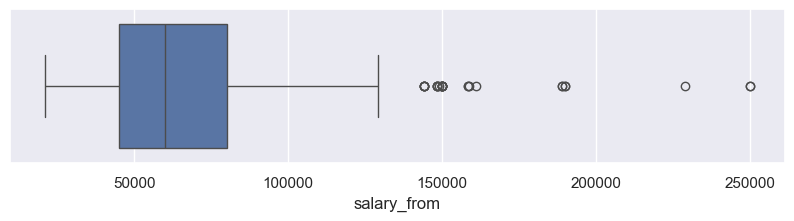

In [111]:
sns.set(rc={'figure.figsize':(10, 2)})

example = data[data.custom_position.str.contains('разнорабочий')]
print(example.shape)
sns.boxplot(example.salary_from, orient='h')

(10588, 322)


<Axes: xlabel='salary_from'>

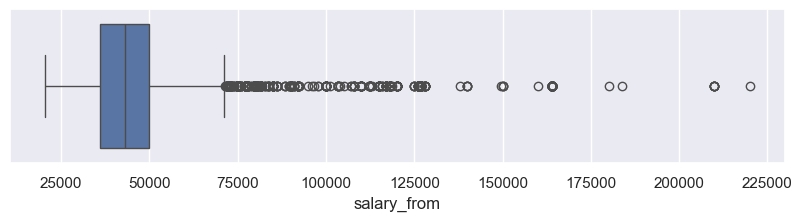

In [112]:
sns.set(rc={'figure.figsize':(10, 2)})

example = data[data.custom_position.str.contains('повар')]
print(example.shape)
sns.boxplot(example.salary_from, orient='h')

(3, 322)


<Axes: xlabel='salary_from'>

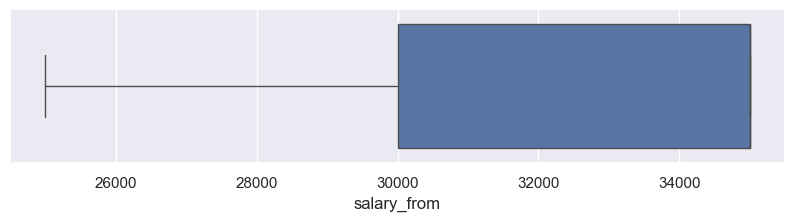

In [113]:
sns.set(rc={'figure.figsize':(10, 2)})

example = data[data.custom_position.str.contains('оператор электронных заявок')]
print(example.shape)
sns.boxplot(example.salary_from, orient='h')

(6666, 322)


<Axes: xlabel='salary_from'>

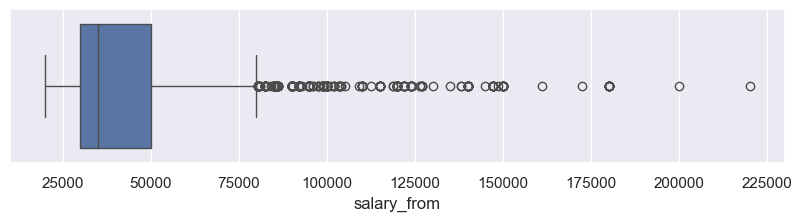

In [117]:
sns.set(rc={'figure.figsize':(10, 2)})

example = data[(data.custom_position.str.contains('оператор'))]
print(example.shape)
sns.boxplot(example.salary_from, orient='h')

In [ ]:
#Большое количество вакансий с повторяющимися словами, но с большим разбросом по зарплате.

### MAPE лучшей модели с другими размерностями эмбеддингов

#### 200

In [72]:
feat_columns = [f"feature_{c}" for c in range(1, 300+1)]

In [77]:
%%time

df_vector_professions_200_train = get_emb_dataframe(train_cust_pos, 200)
X_train_200 = pd.concat([df_vector_professions_200_train, X_train[X_train.columns[~X_train.columns.isin(feat_columns)]].reset_index().drop('index', axis=1)], axis=1, ignore_index=True)

df_vector_professions_200_test = get_emb_dataframe(test_cust_pos, 200)
X_test_200 = pd.concat([df_vector_professions_200_test, X_test[X_test.columns[~X_test.columns.isin(feat_columns)]].reset_index().drop('index', axis=1)], axis=1, ignore_index=True)

CPU times: total: 2min 56s
Wall time: 1min 56s


In [78]:
model = DecisionTreeRegressor()

model.fit(X_train_200, y_train)

DecisionTreeRegressor()

In [79]:
y_train_pred = model.predict(X_train_200)

print('train MAPE: ',mean_absolute_percentage_error(y_train, y_train_pred))

y_test_pred = model.predict(X_test_200)

print('test MAPE: ', mean_absolute_percentage_error(y_test, y_test_pred))

train MAPE:  0.06593819596584449
test MAPE:  0.0974239554053906


#### 100

In [80]:
%%time

df_vector_professions_100_train = get_emb_dataframe(train_cust_pos, 100)
X_train_100 = pd.concat([df_vector_professions_100_train, X_train[X_train.columns[~X_train.columns.isin(feat_columns)]].reset_index().drop('index', axis=1)], axis=1, ignore_index=True)

df_vector_professions_100_test = get_emb_dataframe(test_cust_pos, 100)
X_test_100 = pd.concat([df_vector_professions_100_test, X_test[X_test.columns[~X_test.columns.isin(feat_columns)]].reset_index().drop('index', axis=1)], axis=1, ignore_index=True)

CPU times: total: 2min 13s
Wall time: 1min 12s


In [81]:
model = DecisionTreeRegressor()

model.fit(X_train_100, y_train)

DecisionTreeRegressor()

In [82]:
y_train_pred = model.predict(X_train_100)

print('train MAPE: ',mean_absolute_percentage_error(y_train, y_train_pred))

y_test_pred = model.predict(X_test_100)

print('test MAPE: ',mean_absolute_percentage_error(y_test, y_test_pred))

train MAPE:  0.06593819596584449
test MAPE:  0.09705590577099299


In [ ]:
#Ничего особенно не поменялось. В основном в вакансиях небольшое количество слов.